In [1]:
import copy
from collections import defaultdict
from itertools import product
from pathlib import Path
from typing import Callable, List, Dict, Tuple, Union, Any

from bella import lexicons
from bella.tokenisers import ark_twokenize
from bella import parsers
from bella.data_types import TargetCollection
from bella.word_vectors import VoVectors, SSWE, GloveCommonCrawl
from bella.models import target
from bella.models.base import SKLearnModel
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd
import seaborn as sns
from textwrap import wrap

import config
import thesis_statistics as thesis_stats


matplotlib.rc('font', size=14)
matplotlib.rc('axes', titlesize=14)
matplotlib.rc('axes', labelsize=14)
matplotlib.rc('legend', fontsize=10)
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)
sns.set_style("whitegrid")

def all_words(tokeniser: Callable[[str], List[str]], 
              *datasets) -> List[str]:
    '''
    :returns: All unique tokens/words from the given datasets 
              using the tokeniser given.
    '''
    words = []
    for dataset in datasets:
        words.extend(dataset.word_list(tokeniser))
    words = list(set(words))
    return words

def method_predictions(train: TargetCollection, test: TargetCollection, 
                       model: SKLearnModel, save_dir: Path,
                       save_name_addon: str = '') -> np.ndarray:
    '''
    Given a training and test dataset, it will run train the model and 
    make predictions on the test datasets, of wich those results will be 
    saved. The results from the test predictions will be returned. 
    If the results already exist the model will not be re-trained 
    but rather the saved predictions will be returned (caching). 
    '''
    dataset_name = train.name.split()[0]
    save_dir = Path(save_dir, model.name())
    save_dir.mkdir(parents=True, exist_ok=True)
    if save_name_addon != '':
        save_file = Path(save_dir, f'Reproduction {save_name_addon} {dataset_name}.npy')
    else:
        save_file = Path(save_dir, f'Reproduction {dataset_name}.npy')
    if save_file.exists():
        return np.load(save_file)
    
    X_train = train.data_dict()
    X_test = test.data_dict()
    y_train = train.sentiment_data()
    
    model.fit(X_train, y_train)
    raw_predictions = model.predict(X_test)
    np.save(save_file, raw_predictions)
    return raw_predictions

def feature_predictions(x_train: np.ndarray, y_train: np.ndarray, 
                        x_test: np.ndarray, 
                        dataset_name: str, model_name: str, 
                        model: SKLearnModel, save_dir: Path,
                        fold_number: int = None
                        ) -> np.ndarray:
    '''
    Compared to `predictions` this allows more flexiability in 
    where to save the data too. This is mainly used when 
    performing cross validation.
    '''
    save_dir.mkdir(parents=True, exist_ok=True)
    save_file = Path(save_dir, f'{dataset_name} {model_name}.npy')
    if fold_number is not None:
        save_file = Path(save_dir, f'{dataset_name} fold {fold_number} {model_name}.npy')
    if save_file.exists():
        return np.load(save_file)
    model.fit(x_train, y_train)
    raw_predictions = model.predict(x_test)
    np.save(save_file, raw_predictions)
    return raw_predictions

def multi_metric_df(p_values: Dict[str, pd.DataFrame]) -> pd.DataFrame:
    '''
    Creates a DataFrame whereby the dataframes in the values of the 
    given dictionary are concatenated together column wise. The 
    key values in the given dictionary are used to create the top 
    level column index. 
    '''
    p_values_temp = copy.deepcopy(p_values)
    all_p_values = []
    for metric_name, p_value in p_values_temp.items():
        columns = p_value.columns
        new_columns = list(product([metric_name], columns))
        p_value.columns = pd.MultiIndex.from_tuples(new_columns)
        all_p_values.append(p_value)
    return pd.concat(all_p_values, 1)

def plot_score_confidences(scores: np.ndarray, confidences: np.ndarray,
                           x_values: List[Union[str, int, float]], 
                           ax: matplotlib.axes,
                           x_label: str, y_label: str, title: str = '',
                           **plot_kwargs) -> 'matplotlib.axes.Axes':
    '''
    Given point estimate(s) and the confidence range(s) will plot the estimates
    and confidences as an error bar plot.

    :param scores: Vector of point estimate(s), shape = [n]
    :param confidences: Vector of confidence range(s), shape = []
    :param x_values: List of values to put on the X axis e.g. names of the
                     models that created the point estimates.
    :param ax: A Matplotlib axes to draw with.
    :param x_label: Label to assign to the X axis.
    :param y_label: Label to assign to the Y axis.
    :param title: Title of the plot. Optional if '' given then no title.
    :param **plot_kwargs: Keyword arguments to the
                          :py:func:`matplotlib.axes.Axes.errorbar`
    :return: The matplotlib axes that stores the plot information as an error
             bar plot.
    '''
    num_scores = scores.shape[0]
    scores = scores.reshape((num_scores, 1))
    yerrs = np.abs((scores - confidences).T)
    for i, x in enumerate(x_values):
        yerr = yerrs[:, i].reshape((2, 1))
        if i!=0 and 'label' in plot_kwargs:
            plot_kwargs.pop('label')
        ax.errorbar([x_values[i]], scores[i], yerr=yerr,
                    fmt="bo", capsize=5, zorder=i, **plot_kwargs)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    if title:
        ax.set_title(title)
    return ax

def plot_model_metrics(y_test: np.ndarray, preds: np.ndarray, 
                       metric: Callable[[np.ndarray, np.ndarray], float], 
                       **metric_kwargs) -> np.ndarray:
    model_metric = [metric(y_test, pred, **metric_kwargs) for pred in preds]
    return np.array(model_metric) * 100

def confidence_plots(predictions: np.ndarray, boot_predictions: List[np.ndarray], 
                     y_test: np.ndarray, 
                     metrics: List[Callable[[np.ndarray, np.ndarray], float]], 
                     metrics_kwargs: List[Union[None, Dict[str, Any]]],
                     metric_names: List[str], model_names: List[str],
                     original_scores: List[float], dataset_name: str,
                     model_group_name: str,
                     figsize: Tuple[int, int] = (15, 7)):
    
    number_metrics = len(metric_names)
    fig, axs = plt.subplots(1, number_metrics, figsize=figsize)
    model_names = ['\n'.join(wrap(name, 15)) 
                   for name in model_names]
    
    for metric_index, boot_prediction in enumerate(boot_predictions):
        metric_name = metric_names[metric_index]
        confidence_ranges = [thesis_stats.confidence_range(boot_preds, 0.05, 'two') 
                             for boot_preds in boot_prediction.T]
        confidence_ranges = np.array(confidence_ranges) * 100
        
        metric_func = metrics[metric_index]
        metric_kwargs = metrics_kwargs[metric_index]
        if metric_kwargs:
            model_score = plot_model_metrics(y_test, predictions.T, 
                                        metric_func, **metric_kwargs)
        else:
            model_score = plot_model_metrics(y_test, predictions.T, metric_func)
            
        plot_ax = axs[metric_index]
        #plot_title = f'{model_group_name} Models {metric_name} on\n{dataset_name} Test Data'
        plot_title = ''
        plot_ax = plot_score_confidences(model_score, 
                                         confidence_ranges, 
                                         model_names, plot_ax,
                                         'Models', f'{metric_name} (%)',
                                         plot_title,
                                         label='Reproduced')
        plot_ax.plot(model_names, original_scores[metric_index], 'r^', label='Original')
        plot_ax.legend()
    return plot_ax

def mean_std(data: pd.Series) -> str:
   to_percentage = data * 100
   return f'{np.mean(to_percentage):.2f} ({np.std(to_percentage):.2f})'

Using TensorFlow backend.


# Reproduction of [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) target models

In this notebook we explore the different neural pooling models that [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) created for Target Dependent Sentiment Analysis (TDSA). Each of the four methods use different context windows of the text that the target occured in but applied the same 5 neural pooling functions (max, min, average, standard deviation, and product). The four different target methods explored from the paper are the following:

1. Target-Independent (TargetInd) -- Only used the whole context.
2. Target-Dependent Minus (TargetDepMinus) -- - Left, right, and target contexts.
3. Target-Dependent -- Left, right, target, and whole contexts (Union of the first two methods).
4. Target-Dependent Plus -- This incorporated sentiment lexicons by filtering all words that are not in the sentiment lexicon from a given context. This sentiment filtering was applied to the left and right contexts denoted as *LS* and *RS* respectively. In total this method used the left, right, target, whole, *LS*, and *RS* contexts.

In all of the experiments we use the same word vectors which are the concatenation of the Twitter Word2Vec embeddings (100 dimension embeddings) from their paper and the Sentiment Specific Word Embeddings (SSWE) (50 dimension embeddings) from [Tang et al. 2014](https://www.aclweb.org/anthology/P14-1146.pdf). Additionally we load the [GloVe 300 dimension 840 billion token embeddings](https://nlp.stanford.edu/projects/glove/) as we evaluate later if these embeddings are any better than the ones originally used. We also use the same TitterNLP tokenizer ([Gimpel et al. 2011](https://www.cs.cmu.edu/~ark/TweetNLP/gimpel+etal.acl11.pdf)) (in the Bella package it is called `ark_twokenize`).

## Load the data, embeddings, and sentiment lexicons.

First we load the data that [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) evaluated on, which was the Twitter dataset from [Dong et al. 2014](https://www.aclweb.org/anthology/P14-2009.pdf). We then load the word embeddings used. Finally load the sentiment lexicons that are used in the Target-Dependent Plus method. 

The sentiment lexicons used are the following:

1. MPQA [Wilson et al. 2005](https://www.aclweb.org/anthology/H05-1044/).
2. NRC [Mohammad and Turney 2010](https://www.aclweb.org/anthology/W10-0204/).
3. HL [Hu and Liu 2004](https://www.cs.uic.edu/~liub/publications/kdd04-revSummary.pdf)

More specifically for the final version used the combination of all three sentiment lexicons, whereby they only used the words that were in the positive and negative sentiment category within each of the three sentiment lexicons. Furthermore when the lexicons are combined if any of the words from two lexicons have conflicting sentiment values then that word is removed from the combined lexicon e.g. if the word crude is positive in lexicon 1 and negative in lexicon 2 when lexicon 1 and 2 is combined the result would not contain the word crude.

In [2]:
# Load the datasets
dong_train = parsers.dong(config.DONG_TRAIN, name='Dong Train')
dong_test = parsers.dong(config.DONG_TEST, name='Dong Test')

# Find all the words/tokens in the datasets so that we can reduce 
# the word vectors so that they only contain relevant words
dong_words = all_words(ark_twokenize, dong_train, dong_test)
print(f'Total number of unique words in Dong Twitter dataset {len(dong_words)}')
# Loading the embeddings
# Word Vectors filtered by the dataset words
sswe_dong = SSWE(filter_words=dong_words)
w2v_dong = VoVectors(filter_words=dong_words)
#glove_dong = GloveCommonCrawl(version=840, skip_conf=True, 
#                              filter_words=dong_words)
glove_dong = w2v_dong
# Load the sentiment lexicons so that they only use words that come from 
# the following two semantic categories: 1. Positive and 2. Negative
subset_cats = {'positive', 'negative'}
mpqa = lexicons.Mpqa(config.MPQA, 
                     subset_cats=subset_cats, lower=True)
hu_liu = lexicons.HuLiu(config.HL, 
                        subset_cats=subset_cats, lower=True)
nrc = lexicons.NRC(config.NRC, subset_cats=subset_cats, lower=True)
# Combining the lexicons together
mpqa_huliu = lexicons.Lexicon.combine_lexicons(mpqa, hu_liu)
all_lexicons = lexicons.Lexicon.combine_lexicons(mpqa_huliu, nrc)

tokens_in_lexicon = lambda lexicon, name: f'Number of words in lexicon {name}: {len(lexicon.lexicon)}'
print(tokens_in_lexicon(mpqa, 'MPQA'))
print(tokens_in_lexicon(nrc, 'NRC'))
print(tokens_in_lexicon(hu_liu, 'Hu and Liu'))

Total number of unique words in Dong Twitter dataset 15921
Number of words in lexicon MPQA: 6446
Number of words in lexicon NRC: 5474
Number of words in lexicon Hu and Liu: 6783


### Statistics of the lexicons

Table 1 of [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) shows the statistics of the lexicons that were used. Blow we compare their statistics to ours, of which it can be seen for the majority of cases the same lexicon counts occured and in the cases where they differ, the count difference is small $< 80$.

In [3]:
# Lexicon statistics from Vo et al. 2015 paper
lexicon_names = ['MPQA', 'HL', 'NRC', 'MPQA & HL', 'All Three',
                 'MPQA', 'HL', 'NRC', 'MPQA & HL', 'All Three']
reproduction_names = ['Original', 'Original', 'Original', 'Original', 'Original',
                      'Original', 'Original', 'Original', 'Original', 'Original']
count_names = ['Positive', 'Positive', 'Positive', 'Positive', 'Positive',
               'Negative', 'Negative', 'Negative', 'Negative', 'Negative']
counts = [2289, 2003, 2231, 2706, 3940, 4114, 4780, 3243, 5069, 6490]
# Lexicon statistics from the lexicons loaded here (reproduction lexicon stats)
lexicon_mapper = {mpqa: 'MPQA', hu_liu: 'HL', nrc: 'NRC', 
                  mpqa_huliu: 'MPQA & HL', all_lexicons: 'All Three'}
for lexicon in [mpqa, hu_liu, nrc, mpqa_huliu, all_lexicons]:
    for sentiment_value in ['positive', 'negative']:
        count = [word for word, value in lexicon.lexicon 
                 if value == sentiment_value]
        count = len(set(count))
        counts.append(count)
        reproduction_names.append('Reproduction')
        count_names.append(sentiment_value.capitalize())
        lexicon_names.append(lexicon_mapper[lexicon])
lexicon_stat_dict = {'Lexicon': lexicon_names, 
                     'Reproduction': reproduction_names, 
                     'Sentiment': count_names, 'Count': counts}
lexicon_stat_df = pd.DataFrame(lexicon_stat_dict)
lexicon_stat_df = pd.pivot_table(index='Lexicon', values='Count', 
                                 columns=['Sentiment', 'Reproduction'], 
                                 data=lexicon_stat_df)
lexicon_stat_df = lexicon_stat_df.reindex(['MPQA', 'HL', 'NRC', 'MPQA & HL', 'All Three'])
lexicon_stat_df    

Sentiment    Negative              Positive             
Reproduction Original Reproduction Original Reproduction
Lexicon                                                 
MPQA             4114         4148     2289         2298
HL               4780         4780     2003         2003
NRC              3243         3243     2231         2231
MPQA & HL        5069         5076     2706         2725
All Three        6490         6526     3940         4016

## Experiments
We now move on to performing the majority of the experiments that [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) performed. We first perform the development experiments which involve testing the following two affects:

1. Different sentiment lexicons for the Target Dependent Plus method.
2. Different word embeddings.

All development experiments are evaluated using 5 fold cross validation on the training data.

After that the comparison between methods is performed using the lexicons and word embeddings that were found best in [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf), whereby each method is trained on the training data and tested on the test data.

**NOTE** For all experiments we are going to use the same C-Values for the SVM as [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) used, which they found through cross validation on the training data. The C-Value for Target Dependent Plus is not stated so we assume it to be the same as the C-Value found for the Target Dependent method. 

### Development Experiments
#### Lexicons

Here we are going to compare the 5 lexicons when incorporated into the Target Dependent Plus model with each other and the non-lexicon version Target Dependent:

In [4]:
# models being tested
target_dep = target.TargetDep([w2v_dong], C=0.01)
target_dep_plus_mpqa = target.TargetDepPlus([w2v_dong], mpqa, C=0.01)
target_dep_plus_hl = target.TargetDepPlus([w2v_dong], hu_liu, C=0.01)
target_dep_plus_nrc = target.TargetDepPlus([w2v_dong], nrc, C=0.01)
target_dep_plus_mpqa_hl = target.TargetDepPlus([w2v_dong], mpqa_huliu, C=0.01)
target_dep_plus_all = target.TargetDepPlus([w2v_dong], all_lexicons, C=0.01)
lexicon_models = [target_dep, target_dep_plus_mpqa, target_dep_plus_hl, 
                  target_dep_plus_nrc, target_dep_plus_mpqa_hl,
                  target_dep_plus_all]
lexicon_names = ['', 'MPQA', 'HL', 'NRC', 'MPQA & HL', 'All Three']

dong_train_x = np.array(dong_train.data())
dong_train_y = np.array(dong_train.sentiment_data())
fold_creator = StratifiedKFold(5, random_state=42)

lexicon_results_directory = config.RESULTS_DIR / 'vo_lexicon_experiments'
fold_number = 0

model_names = ['Target Dependent', 'Target Dependent Plus MPQA',
               'Target Dependent Plus HL', 'Target Dependent Plus NRC',
               'Target Dependent Plus MPQA & HL',
               'Target Dependent Plus All Three']
accuracies = [.6572, .6556, .6724, .6605, .6740, .6730]
f1s = [0,0,0,0,0,0]
reproduction_names = ['Original', 'Original', 'Original', 'Original', 'Original',
                      'Original']

lexicon_cross_val_preds: Dict[int, Tuple[List[str], np.ndarray, np.ndarray]] = {}
for train_index, test_index in fold_creator.split(dong_train_x, dong_train_y):
    #print(fold_number)
    x_train, x_test = dong_train_x[train_index], dong_train_x[test_index]
    y_train, y_test = dong_train_y[train_index], dong_train_y[test_index]
    fold_predictions = []
    fold_model_names = []
    for model_index, model in enumerate(lexicon_models):
        model_name = model.name()
        lexicon_name = lexicon_names[model_index]
        if lexicon_name:
            model_name = f'{model_name} {lexicon_name}'
        #print(model_name)
        predictions = feature_predictions(x_train, y_train, x_test, 
                                          dataset_name='Dong', 
                                          model_name=model_name, model=model,
                                          save_dir=lexicon_results_directory,
                                          fold_number=fold_number)
        accuracies.append(accuracy_score(y_test, predictions))
        f1s.append(f1_score(y_test, predictions, average='macro'))
        model_names.append(model_name)
        reproduction_names.append('Reproduction')
        fold_predictions.append(np.expand_dims(np.array(predictions), 1))
        fold_model_names.append(model_name)
    fold_predictions = np.concatenate(fold_predictions, 1)
    lexicon_cross_val_preds[fold_number] = (fold_model_names, fold_predictions, y_test)
    fold_number += 1
lexicon_results = pd.DataFrame({'Model': model_names, 
                                'Reproduction': reproduction_names,
                                'Accuracy': accuracies, 'F1': f1s})
lexicon_results = pd.pivot_table(data=lexicon_results, values=['Accuracy', 'F1'],
                                 columns='Reproduction', 
                                 index='Model', aggfunc=mean_std)        
lexicon_results.reindex(['Target Dependent', 'Target Dependent Plus MPQA',
                         'Target Dependent Plus HL', 'Target Dependent Plus NRC',
                         'Target Dependent Plus MPQA & HL',
                         'Target Dependent Plus All Three'])


Accuracy                         F1  \
Reproduction                         Original  Reproduction     Original   
Model                                                                      
Target Dependent                 65.72 (0.00)  66.81 (0.86)  0.00 (0.00)   
Target Dependent Plus MPQA       65.56 (0.00)  66.81 (1.20)  0.00 (0.00)   
Target Dependent Plus HL         67.24 (0.00)  68.61 (1.00)  0.00 (0.00)   
Target Dependent Plus NRC        66.05 (0.00)  67.13 (0.80)  0.00 (0.00)   
Target Dependent Plus MPQA & HL  67.40 (0.00)  68.37 (1.17)  0.00 (0.00)   
Target Dependent Plus All Three  67.30 (0.00)  68.23 (1.11)  0.00 (0.00)   

                                               
Reproduction                     Reproduction  
Model                                          
Target Dependent                 62.66 (1.16)  
Target Dependent Plus MPQA       63.18 (1.50)  
Target Dependent Plus HL         65.37 (1.20)  
Target Dependent Plus NRC        63.41 (0.98)  
Target Dependent Plus MPQA & HL  65.04 (1.39)  
Target Dependent Plus All Three  64.88 (1.41)

As we can see from above not all lexicons help equally. For instance the MPQA lexicon marginally improves over not using a lexicon where as the HL and lexicon is by far the best single lexicon. These findings match those from the original paper. Additionally it shows that using all three lexicons is not the best combination, which is also what the original paper found. However the original paper shows that the best lexicon is the combination of the MPQA and HL where as the results found in the reproduction show that just the HL lexicon is best.

Below we examine if the best sentiment lexicon found in the reproduction is singificantly better than all the other lexicons, lexicon combinations, and not using a lexicon.

In [5]:
accuracy_p_values = []
f1_p_values = []
for fold in lexicon_cross_val_preds.keys():
    model_names, predictions, true_values = lexicon_cross_val_preds[fold]
    # Accuracy P values for Target Dependent Plus HL
    lexicon_bootstrap_acc_preds = thesis_stats.bootstrap(true_values, predictions, accuracy_score, n=10000)
    lexicon_acc_p_values = thesis_stats.bootstrap_one_t_test(lexicon_bootstrap_acc_preds, model_names)
    accuracy_p_values.append(lexicon_acc_p_values['Target Dependent Plus HL'])
    # F1 P values for Target Dependent Plus HL
    lexicon_bootstrap_f1_preds = thesis_stats.bootstrap(true_values, predictions, f1_score, average='macro', n=10000)
    lexicon_f1_p_values = thesis_stats.bootstrap_one_t_test(lexicon_bootstrap_f1_preds, model_names)
    f1_p_values.append(lexicon_f1_p_values['Target Dependent Plus HL'])
# Convert them into a DataFrame
lex_f1_p_values = pd.concat(f1_p_values, 1)
lex_accuracy_p_values = pd.concat(accuracy_p_values, 1)
lex_accuracy_p_values.reindex(['Target Dependent', 'Target Dependent Plus MPQA',
                               'Target Dependent Plus HL', 'Target Dependent Plus NRC',
                               'Target Dependent Plus MPQA & HL',
                               'Target Dependent Plus All Three'])

,Target Dependent Plus HL,Target Dependent Plus HL,Target Dependent Plus HL,Target Dependent Plus HL,Target Dependent Plus HL
Target Dependent,0.0614,0.0638,0.0003,0.0242,0.1336
Target Dependent Plus MPQA,0.1152,0.0287,0.0002,0.0007,0.0661
Target Dependent Plus HL,1.0000,1.0000,1.0000,1.0000,1.0000
Target Dependent Plus NRC,0.2028,0.0182,0.0006,0.0718,0.1342
Target Dependent Plus MPQA & HL,0.6722,0.4702,0.1206,0.0870,0.6856
Target Dependent Plus All Three,0.3021,0.3930,0.3528,0.2168,0.3290


Above and below are the P-Values for the accuracy and Macro F1 metric when comparing the different sentiment lexicon across the five folds to the HL sentiment lexicon method. The columns represent each fold and the rows represent the compared sentiment lexicon methods. As we can see both metrics have folds that contain singificant differences whereby the two lexicons which are not significantly different on any of the folds is MPQA & HL and All Three. The MPQA & HL is the lexicon combination that the original paper found best. This potentially indicates that the most important lexicon is the HL lexicon as this lexicon occurs in all of the methods that are not significantly different.

To see if these siginificant difference hold when we correct for multiple comparison using the Bonferroni correction see the table below the F1 P-values:

In [6]:
lex_f1_p_values.reindex(['Target Dependent', 'Target Dependent Plus MPQA',
                         'Target Dependent Plus HL', 'Target Dependent Plus NRC',
                         'Target Dependent Plus MPQA & HL',
                         'Target Dependent Plus All Three'])

,Target Dependent Plus HL,Target Dependent Plus HL,Target Dependent Plus HL,Target Dependent Plus HL,Target Dependent Plus HL
Target Dependent,0.0264,0.0351,0.0000,0.0011,0.0358
Target Dependent Plus MPQA,0.0814,0.0318,0.0001,0.0000,0.0476
Target Dependent Plus HL,1.0000,1.0000,1.0000,1.0000,1.0000
Target Dependent Plus NRC,0.1591,0.0083,0.0000,0.0360,0.0701
Target Dependent Plus MPQA & HL,0.7129,0.3968,0.0671,0.0593,0.5737
Target Dependent Plus All Three,0.2398,0.4200,0.3658,0.1203,0.2404


In [7]:
f1_folds_better = []
accuracy_folds_better = []
model_names = []
for model in lex_f1_p_values.index:
    if model == 'Target Dependent Plus HL':
        continue
    f1_model_p_values = lex_f1_p_values.loc[model].tolist()
    accuracy_model_p_values = lex_accuracy_p_values.loc[model].tolist()
    number_times_sig_better = thesis_stats.find_k_estimator(f1_model_p_values, alpha=0.05)
    f1_folds_better.append(number_times_sig_better)
    number_times_sig_better = thesis_stats.find_k_estimator(accuracy_model_p_values, alpha=0.05)
    accuracy_folds_better.append(number_times_sig_better)
    model_names.append(model)
lexicon_corrected_df = {'F1': f1_folds_better, 'Accuracy': accuracy_folds_better, 
                        'Model': model_names}
lexicon_corrected_df = pd.DataFrame(lexicon_corrected_df)
lexicon_corrected_df = pd.pivot_table(data=lexicon_corrected_df, 
                                      index='Model', values=['F1', 'Accuracy']) 
lexicon_corrected_df.reindex(['Target Dependent', 'Target Dependent Plus MPQA',
                              'Target Dependent Plus NRC',
                              'Target Dependent Plus MPQA & HL',
                              'Target Dependent Plus All Three'])

,Accuracy,F1
Model,,
Target Dependent,1,2
Target Dependent Plus MPQA,2,2
Target Dependent Plus NRC,1,2
Target Dependent Plus MPQA & HL,0,0
Target Dependent Plus All Three,0,0


As we can see after correcting the P-values using Bonferroni at least one fold for the lexicons that contained a significant difference is singificantly different on both metrics. This shows with a higher level of confidence that sentiment lexicons are useful within this method, in comparison to the original study which never showed any significance testing thus could not have the same level of confidence that sentiment lexicons were useful.

In the [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) paper they found MPQA + HL the best sentiment lexicon and for the rest of their original experiments they carried on using those lexicons and thus so do we here.

#### Embeddings

Here we compare the three embeddings that were compared in [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf). Additionally we also compare the GloVe 300 dimension embeddings which were not evaluated/used in [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) but are well used in the literature.:

1. Their Twitter Word2Vec embeddings (100 dimension embeddings) (w2v).
2. SSWE (50 dimension embeddings) from [Tang et al. 2014](https://www.aclweb.org/anthology/P14-1146.pdf).
3. Concatenation of the two (SSWE + w2v).
4. [GloVe 300 dimension 840 billion token](https://nlp.stanford.edu/projects/glove/).

In [8]:
# models being tested
all_embedding_models = []
for embedding in [[w2v_dong], [sswe_dong], [sswe_dong, w2v_dong], [glove_dong]]:
    _embedding_models = []
    _embedding_models.append(target.TargetInd(embedding, C=0.12))
    _embedding_models.append(target.TargetDepMinus(embedding, C=0.025))
    _embedding_models.append(target.TargetDep(embedding, C=0.01))
    _embedding_models.append(target.TargetDepPlus(embedding, 
                                                  senti_lexicon=mpqa_huliu, 
                                                  C=0.01))
    all_embedding_models.append(_embedding_models)

embedding_names = ['w2v', 'SSWE', 'SSWE + w2v', 'GloVe']

dong_train_x = np.array(dong_train.data())
dong_train_y = np.array(dong_train.sentiment_data())
fold_creator = StratifiedKFold(5, random_state=42)

embedding_results_directory = config.RESULTS_DIR / 'vo_embedding_experiments'
fold_number = 0

model_names = ['Target Independent', 'Target Independent',
               'Target Independent', 'Target Independent',
               'Target Dependent Minus', 'Target Dependent Minus',
               'Target Dependent Minus', 'Target Dependent Minus', 
               'Target Dependent', 'Target Dependent', 'Target Dependent',
               'Target Dependent', 'Target Dependent Plus',  
               'Target Dependent Plus', 'Target Dependent Plus',
               'Target Dependent Plus']
embedding_names_df = ['w2v', 'SSWE', 'SSWE + w2v', 'GloVe', 'w2v', 'SSWE', 
                      'SSWE + w2v', 'GloVe', 'w2v', 'SSWE', 'SSWE + w2v', 
                      'GloVe', 'w2v', 'SSWE', 'SSWE + w2v', 'GloVe'] 
accuracies = [.592, .607, .623, 0, .654, .666, .676, 0, .657, .667, .683, 0,
              .674, .679, .691, 0]
f1s = [0,0,0,0,0,0, 0,0,0,0,0,0,0,0,0,0]
reproduction_names = ['Original', 'Original', 'Original', 'Original', 'Original',
                      'Original', 'Original', 'Original', 'Original', 'Original',
                      'Original','Original', 'Original','Original',
                      'Original','Original']

method_embedding_cross_val_preds: Dict[str, Dict[int, Tuple[List[str], np.ndarray, np.ndarray]]] = defaultdict(lambda: dict())
for train_index, test_index in fold_creator.split(dong_train_x, dong_train_y):
    #print(fold_number)
    x_train, x_test = dong_train_x[train_index], dong_train_x[test_index]
    y_train, y_test = dong_train_y[train_index], dong_train_y[test_index]
    for embedding_index, embedding_models in enumerate(all_embedding_models):
        embedding_name = embedding_names[embedding_index]
        for embedding_model in embedding_models:
            original_model_name = embedding_model.name()
            model_name = f'{original_model_name} {embedding_name}'
            #print(model_name)
            predictions = feature_predictions(x_train, y_train, x_test, 
                                              dataset_name='Dong', 
                                              model_name=model_name, model=embedding_model,
                                              save_dir=embedding_results_directory,
                                              fold_number=fold_number)
            model_names.append(original_model_name)
            accuracies.append(accuracy_score(y_test, predictions))
            f1s.append(f1_score(y_test, predictions, average='macro'))
            reproduction_names.append('Reproduction')
            embedding_names_df.append(embedding_name)

            np_preds = np.expand_dims(np.array(predictions), 1)
            if fold_number not in method_embedding_cross_val_preds[original_model_name]:
                method_embedding_cross_val_preds[original_model_name][fold_number] = ([embedding_name], np_preds, y_test)
            else:
                current_embedding_names, current_preds, _ = method_embedding_cross_val_preds[original_model_name][fold_number]
                current_embedding_names.append(embedding_name)
                np_preds = np.concatenate([current_preds, np_preds], 1)
                method_embedding_cross_val_preds[original_model_name][fold_number] = (current_embedding_names, np_preds, y_test)


    fold_number += 1
embedding_results_dict = {'Reproduction': reproduction_names, 'F1': f1s,
                          'Accuracy': accuracies, 'Model': model_names,
                          'Embedding': embedding_names_df}
embedding_results_df = pd.DataFrame(embedding_results_dict)
embedding_results_pivot_df = pd.pivot_table(data=embedding_results_df, 
                                            values=['Accuracy', 'F1'], 
                                            index=['Model', 'Embedding'], 
                                            columns='Reproduction', 
                                            aggfunc=mean_std)
embedding_results_df_index = product(['Target Independent', 'Target Dependent Minus',
                                      'Target Dependent', 'Target Dependent Plus'], 
                                      ['w2v', 'SSWE', 'SSWE + w2v', 'GloVe'])
embedding_results_df_index = list(embedding_results_df_index)
embedding_results_pivot_df.reindex(embedding_results_df_index)

        


Accuracy                         F1  \
Reproduction                           Original  Reproduction     Original   
Model                  Embedding                                             
Target Independent     w2v         59.20 (0.00)  60.96 (0.60)  0.00 (0.00)   
                       SSWE        60.70 (0.00)  60.58 (1.08)  0.00 (0.00)   
                       SSWE + w2v  62.30 (0.00)  62.24 (0.91)  0.00 (0.00)   
                       GloVe        0.00 (0.00)  63.72 (1.76)  0.00 (0.00)   
Target Dependent Minus w2v         65.40 (0.00)  65.67 (1.11)  0.00 (0.00)   
                       SSWE        66.60 (0.00)  66.74 (0.48)  0.00 (0.00)   
                       SSWE + w2v  67.60 (0.00)  67.46 (1.04)  0.00 (0.00)   
                       GloVe        0.00 (0.00)  67.41 (0.78)  0.00 (0.00)   
Target Dependent       w2v         65.70 (0.00)  66.81 (0.86)  0.00 (0.00)   
                       SSWE        66.70 (0.00)  66.37 (0.59)  0.00 (0.00)   
                       SSWE + w2v  68.30 (0.00)  68.02 (0.82)  0.00 (0.00)   
                       GloVe        0.00 (0.00)  68.69 (1.13)  0.00 (0.00)   
Target Dependent Plus  w2v         67.40 (0.00)  68.37 (1.17)  0.00 (0.00)   
                       SSWE        67.90 (0.00)  67.72 (1.11)  0.00 (0.00)   
                       SSWE + w2v  69.10 (0.00)  69.05 (1.19)  0.00 (0.00)   
                       GloVe        0.00 (0.00)  68.98 (1.09)  0.00 (0.00)   

                                                 
Reproduction                       Reproduction  
Model                  Embedding                 
Target Independent     w2v         56.64 (0.69)  
                       SSWE        56.52 (1.46)  
                       SSWE + w2v  59.16 (0.66)  
                       GloVe       61.31 (1.74)  
Target Dependent Minus w2v         61.38 (1.29)  
                       SSWE        62.77 (0.78)  
                       SSWE + w2v  64.18 (1.18)  
                       GloVe       64.11 (0.82)  
Target Dependent       w2v         62.66 (1.16)  
                       SSWE        62.41 (0.81)  
                       SSWE + w2v  64.90 (0.91)  
                       GloVe       65.68 (1.24)  
Target Dependent Plus  w2v         65.04 (1.39)  
                       SSWE        64.39 (1.54)  
                       SSWE + w2v  66.34 (1.41)  
                       GloVe       66.39 (1.23)

We can see from above that the results reproduce those from the original paper with respect to the SSWE + w2v being the best embedding. However we find that in general the SSWE embeddings perform worse than the w2v which is not what the original paper found. Furthermore the GloVe embeddings perform best for two out of the four methods across both metrics even though the embeddings are not type nor task specific compared to SSWE + w2v.

In [9]:
all_accuracy_p_values = []
all_f1_p_values = []

for embedding_model_name, fold_cross_val_preds in method_embedding_cross_val_preds.items():
    accuracy_p_values = []
    f1_p_values = []
    for cross_val_preds in fold_cross_val_preds.values():
        model_names, predictions, true_values = cross_val_preds
        # Accuracy P values for Target Dependent Plus HL
        embedding_bootstrap_acc_preds = thesis_stats.bootstrap(true_values, predictions, accuracy_score, n=10000)
        embedding_acc_p_values = thesis_stats.bootstrap_one_t_test(embedding_bootstrap_acc_preds, model_names)
        accuracy_p_values.append(embedding_acc_p_values['SSWE + w2v'])
        # F1 P values for Target Dependent Plus HL
        embedding_bootstrap_f1_preds = thesis_stats.bootstrap(true_values, predictions, f1_score, average='macro', n=10000)
        embedding_f1_p_values = thesis_stats.bootstrap_one_t_test(embedding_bootstrap_f1_preds, model_names)
        f1_p_values.append(embedding_f1_p_values['SSWE + w2v'])
    # Convert them into a DataFrame
    f1_p_values = pd.concat(f1_p_values, 1)
    f1_p_values['Model'] = [embedding_model_name] * f1_p_values.shape[0]
    all_f1_p_values.append(f1_p_values)
    accuracy_p_values = pd.concat(accuracy_p_values, 1)
    accuracy_p_values['Model'] = [embedding_model_name] * f1_p_values.shape[0]
    all_accuracy_p_values.append(accuracy_p_values)

temp_all_f1_p_values = []
for value in all_f1_p_values:
    temp_all_f1_p_values.append(value.reset_index().set_index(['Model', 'index']))
temp_all_accuracy_p_values = []
for value in all_accuracy_p_values:
    temp_all_accuracy_p_values.append(value.reset_index().set_index(['Model', 'index']))
pd.concat(temp_all_f1_p_values)

SSWE + w2v  SSWE + w2v  SSWE + w2v  \
Model                  index                                            
Target Independent     w2v             0.0041      0.0055      0.0376   
                       SSWE            0.1078      0.0031      0.0345   
                       SSWE + w2v      1.0000      1.0000      1.0000   
                       GloVe           0.9130      0.9985      0.8043   
Target Dependent Minus w2v             0.2428      0.0025      0.0000   
                       SSWE            0.0366      0.0215      0.0959   
                       SSWE + w2v      1.0000      1.0000      1.0000   
                       GloVe           0.8694      0.4331      0.0749   
Target Dependent       w2v             0.0137      0.0054      0.0030   
                       SSWE            0.0019      0.0004      0.0276   
                       SSWE + w2v      1.0000      1.0000      1.0000   
                       GloVe           0.6809      0.8042      0.2288   
Target Dependent Plus  w2v             0.0187      0.0405      0.0626   
                       SSWE            0.0241      0.0003      0.0105   
                       SSWE + w2v      1.0000      1.0000      1.0000   
                       GloVe           0.5242      0.4867      0.0998   

                                   SSWE + w2v  SSWE + w2v  
Model                  index                               
Target Independent     w2v             0.0207      0.1274  
                       SSWE            0.0015      0.1325  
                       SSWE + w2v      1.0000      1.0000  
                       GloVe           0.6888      0.8482  
Target Dependent Minus w2v             0.0054      0.0014  
                       SSWE            0.4984      0.0725  
                       SSWE + w2v      1.0000      1.0000  
                       GloVe           0.8097      0.2709  
Target Dependent       w2v             0.0058      0.3615  
                       SSWE            0.0179      0.0689  
                       SSWE + w2v      1.0000      1.0000  
                       GloVe           0.7228      0.9645  
Target Dependent Plus  w2v             0.1023      0.3589  
                       SSWE            0.0841      0.3724  
                       SSWE + w2v      1.0000      1.0000  
                       GloVe           0.6927      0.8308

As we can see from the p-values for the F1 scores above and accuracy below in general the SSWE + w2v are only significantly better ($\le0.05$) when compared against the SSWE and w2v embeddings but are never significantly better than the GloVe embeddings. However like the lexicons as there are multiple comparison due to five fold cross validation we apply Bonferroni correction.

In [10]:
pd.concat(temp_all_accuracy_p_values)

SSWE + w2v  SSWE + w2v  SSWE + w2v  \
Model                  index                                            
Target Independent     w2v             0.0194      0.0505      0.1707   
                       SSWE            0.1086      0.0577      0.0578   
                       SSWE + w2v      1.0000      1.0000      1.0000   
                       GloVe           0.7962      0.9957      0.6750   
Target Dependent Minus w2v             0.4704      0.0042      0.0020   
                       SSWE            0.0933      0.0671      0.2708   
                       SSWE + w2v      1.0000      1.0000      1.0000   
                       GloVe           0.8995      0.3796      0.1132   
Target Dependent       w2v             0.1251      0.0161      0.0303   
                       SSWE            0.0101      0.0120      0.0679   
                       SSWE + w2v      1.0000      1.0000      1.0000   
                       GloVe           0.7393      0.8222      0.1851   
Target Dependent Plus  w2v             0.1277      0.1065      0.1814   
                       SSWE            0.0795      0.0027      0.0319   
                       SSWE + w2v      1.0000      1.0000      1.0000   
                       GloVe           0.5692      0.4479      0.0731   

                                   SSWE + w2v  SSWE + w2v  
Model                  index                               
Target Independent     w2v             0.1939      0.4291  
                       SSWE            0.0102      0.4579  
                       SSWE + w2v      1.0000      1.0000  
                       GloVe           0.4912      0.8776  
Target Dependent Minus w2v             0.0361      0.0113  
                       SSWE            0.8652      0.0995  
                       SSWE + w2v      1.0000      1.0000  
                       GloVe           0.8341      0.2367  
Target Dependent       w2v             0.0522      0.6706  
                       SSWE            0.1115      0.1068  
                       SSWE + w2v      1.0000      1.0000  
                       GloVe           0.6677      0.9684  
Target Dependent Plus  w2v             0.2365      0.5587  
                       SSWE            0.2145      0.4430  
                       SSWE + w2v      1.0000      1.0000  
                       GloVe           0.6190      0.8252

After the Bonferroni correction which can be seen below, it shows that indeed SSWE + w2v is singificantly better on many of the folds. Furthermore this is best shown through the F1 metric. However it does show that it is never significantly better than the GloVe embeddings, suggesting that the general non task nor non type specific embeddings are just as good.

In [11]:
f1_folds_better = []
accuracy_folds_better = []
model_names = []
embedding_names = []
for model_index in range(len(all_accuracy_p_values)):
    assert all_accuracy_p_values[model_index]['Model'][0] == all_f1_p_values[model_index]['Model'][0]
    model_name = all_accuracy_p_values[model_index]['Model'][0]
    for embedding_name in ['w2v', 'SSWE', 'GloVe']:
        embedding_names.append(embedding_name)
        model_names.append(model_name)
        accuracy_model_p_values = all_accuracy_p_values[model_index]['SSWE + w2v'].loc[embedding_name].tolist()
        f1_model_p_values = all_f1_p_values[model_index]['SSWE + w2v'].loc[embedding_name].tolist()
        number_times_sig_better = thesis_stats.find_k_estimator(accuracy_model_p_values, alpha=0.05)
        accuracy_folds_better.append(number_times_sig_better)
        number_times_sig_better = thesis_stats.find_k_estimator(f1_model_p_values, alpha=0.05)
        f1_folds_better.append(number_times_sig_better)
        
embedding_corrected_df = {'F1': f1_folds_better, 'Accuracy': accuracy_folds_better, 
                          'Model': model_names, 'Embedding': embedding_names}
embedding_corrected_df = pd.DataFrame(embedding_corrected_df)
embedding_corrected_df = pd.pivot_table(data=embedding_corrected_df, 
                                        index=['Model', 'Embedding'], 
                                        values=['F1', 'Accuracy'])

embedding_corrected_df.reindex(list(product(['Target Independent', 'Target Dependent Minus', 
                                             'Target Dependent', 'Target Dependent Plus'],
                                            ['w2v', 'SSWE', 'GloVe'])))

Accuracy  F1
Model                  Embedding              
Target Independent     w2v               0   2
                       SSWE              0   2
                       GloVe             0   0
Target Dependent Minus w2v               3   4
                       SSWE              0   0
                       GloVe             0   0
Target Dependent       w2v               0   4
                       SSWE              0   2
                       GloVe             0   0
Target Dependent Plus  w2v               0   0
                       SSWE              1   2
                       GloVe             0   0

As we want to now see if the GloVe embeddings are significantly better than the other embeddings using a one sided test the above tests are performed again but now comparing GloVe to the other embeddings:

In [12]:
all_accuracy_p_values = []
all_f1_p_values = []

for embedding_model_name, fold_cross_val_preds in method_embedding_cross_val_preds.items():
    accuracy_p_values = []
    f1_p_values = []
    for cross_val_preds in fold_cross_val_preds.values():
        model_names, predictions, true_values = cross_val_preds
        # Accuracy P values for Target Dependent Plus HL
        embedding_bootstrap_acc_preds = thesis_stats.bootstrap(true_values, predictions, accuracy_score, n=10000)
        embedding_acc_p_values = thesis_stats.bootstrap_one_t_test(embedding_bootstrap_acc_preds, model_names)
        accuracy_p_values.append(embedding_acc_p_values['GloVe'])
        # F1 P values for Target Dependent Plus HL
        embedding_bootstrap_f1_preds = thesis_stats.bootstrap(true_values, predictions, f1_score, average='macro', n=10000)
        embedding_f1_p_values = thesis_stats.bootstrap_one_t_test(embedding_bootstrap_f1_preds, model_names)
        f1_p_values.append(embedding_f1_p_values['GloVe'])
    # Convert them into a DataFrame
    f1_p_values = pd.concat(f1_p_values, 1)
    f1_p_values['Model'] = [embedding_model_name] * f1_p_values.shape[0]
    all_f1_p_values.append(f1_p_values)
    accuracy_p_values = pd.concat(accuracy_p_values, 1)
    accuracy_p_values['Model'] = [embedding_model_name] * f1_p_values.shape[0]
    all_accuracy_p_values.append(accuracy_p_values)

temp_all_f1_p_values = []
for value in all_f1_p_values:
    temp_all_f1_p_values.append(value.reset_index().set_index(['Model', 'index']))
temp_all_accuracy_p_values = []
for value in all_accuracy_p_values:
    temp_all_accuracy_p_values.append(value.reset_index().set_index(['Model', 'index']))
pd.concat(temp_all_f1_p_values)

GloVe   GloVe   GloVe   GloVe   GloVe
Model                  index                                             
Target Independent     w2v         0.0001  0.0000  0.0125  0.0246  0.0278
                       SSWE        0.0120  0.0000  0.0107  0.0014  0.0350
                       SSWE + w2v  0.0904  0.0014  0.1828  0.3076  0.1542
                       GloVe       1.0000  1.0000  1.0000  1.0000  1.0000
Target Dependent Minus w2v         0.0523  0.0159  0.0520  0.0033  0.0635
                       SSWE        0.0099  0.0889  0.6647  0.2007  0.3209
                       SSWE + w2v  0.1325  0.5576  0.9246  0.1876  0.7198
                       GloVe       1.0000  1.0000  1.0000  1.0000  1.0000
Target Dependent       w2v         0.0078  0.0021  0.0640  0.0065  0.0164
                       SSWE        0.0057  0.0015  0.2117  0.0226  0.0017
                       SSWE + w2v  0.3191  0.1955  0.7637  0.2803  0.0334
                       GloVe       1.0000  1.0000  1.0000  1.0000  1.0000
Target Dependent Plus  w2v         0.0575  0.1054  0.5351  0.0542  0.1034
                       SSWE        0.0582  0.0064  0.2749  0.0461  0.1327
                       SSWE + w2v  0.4589  0.5115  0.9006  0.2989  0.1690
                       GloVe       1.0000  1.0000  1.0000  1.0000  1.0000

In [17]:
pd.concat(temp_all_accuracy_p_values)

GloVe   GloVe   GloVe   GloVe   GloVe
Model                  index                                             
Target Independent     w2v         0.0112  0.0002  0.1359  0.2858  0.0954
                       SSWE        0.0403  0.0001  0.0485  0.0375  0.1191
                       SSWE + w2v  0.2157  0.0034  0.3456  0.5330  0.1276
                       GloVe       1.0000  1.0000  1.0000  1.0000  1.0000
Target Dependent Minus w2v         0.1051  0.0469  0.1746  0.0125  0.2010
                       SSWE        0.0176  0.2131  0.7693  0.4632  0.4148
                       SSWE + w2v  0.1169  0.6399  0.8943  0.1793  0.7803
                       GloVe       1.0000  1.0000  1.0000  1.0000  1.0000
Target Dependent       w2v         0.0568  0.0034  0.2774  0.0486  0.0679
                       SSWE        0.0127  0.0072  0.3882  0.0939  0.0041
                       SSWE + w2v  0.2800  0.1882  0.8277  0.3421  0.0351
                       GloVe       1.0000  1.0000  1.0000  1.0000  1.0000
Target Dependent Plus  w2v         0.1747  0.2198  0.7834  0.1974  0.1889
                       SSWE        0.1218  0.0275  0.4635  0.1772  0.1763
                       SSWE + w2v  0.4610  0.5737  0.9357  0.3973  0.1862
                       GloVe       1.0000  1.0000  1.0000  1.0000  1.0000

In [14]:
f1_folds_better = []
accuracy_folds_better = []
model_names = []
embedding_names = []
for model_index in range(len(all_accuracy_p_values)):
    assert all_accuracy_p_values[model_index]['Model'][0] == all_f1_p_values[model_index]['Model'][0]
    model_name = all_accuracy_p_values[model_index]['Model'][0]
    for embedding_name in ['w2v', 'SSWE', 'SSWE + w2v']:
        embedding_names.append(embedding_name)
        model_names.append(model_name)
        accuracy_model_p_values = all_accuracy_p_values[model_index]['GloVe'].loc[embedding_name].tolist()
        f1_model_p_values = all_f1_p_values[model_index]['GloVe'].loc[embedding_name].tolist()
        number_times_sig_better = thesis_stats.find_k_estimator(accuracy_model_p_values, alpha=0.05)
        accuracy_folds_better.append(number_times_sig_better)
        number_times_sig_better = thesis_stats.find_k_estimator(f1_model_p_values, alpha=0.05)
        f1_folds_better.append(number_times_sig_better)
        
embedding_corrected_df = {'F1': f1_folds_better, 'Accuracy': accuracy_folds_better, 
                          'Model': model_names, 'Embedding': embedding_names}
embedding_corrected_df = pd.DataFrame(embedding_corrected_df)
embedding_corrected_df = pd.pivot_table(data=embedding_corrected_df, 
                                        index=['Model', 'Embedding'], 
                                        values=['F1', 'Accuracy'])

embedding_corrected_df.reindex(list(product(['Target Independent', 'Target Dependent Minus', 
                                             'Target Dependent', 'Target Dependent Plus'],
                                            ['w2v', 'SSWE', 'SSWE + w2v'])))

Accuracy  F1
Model                  Embedding               
Target Independent     w2v                2   5
                       SSWE               1   5
                       SSWE + w2v         1   1
Target Dependent Minus w2v                0   1
                       SSWE               0   1
                       SSWE + w2v         0   0
Target Dependent       w2v                1   4
                       SSWE               3   4
                       SSWE + w2v         0   0
Target Dependent Plus  w2v                0   0
                       SSWE               0   1
                       SSWE + w2v         0   0

### Method Comparison

Here we compare the methods using the SSWE + w2v embeddings and the MPQA + HL lexicon for the Target Dependent Plus method on the test split using the same C-Values as [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf) did in table 5.

In [11]:
results_dir = config.RESULTS_DIR
# Run the Target models
target_ind = target.TargetInd([w2v_dong, sswe_dong], C=0.12)
target_dep_minus = target.TargetDepMinus([w2v_dong, sswe_dong], C=0.025)
target_dep = target.TargetDep([w2v_dong, sswe_dong], C=0.01)
target_dep_plus = target.TargetDepPlus([w2v_dong, sswe_dong], mpqa_huliu, C=0.01)

target_models = [target_ind, target_dep_minus, target_dep, target_dep_plus]
target_model_names = ['Target Independent', 'Target Dependent Minus', 
                      'Target Dependent', 'Target Dependent Plus']
target_accuracies = [67.3, 0.0, 69.7, 71.1]
target_f1s = [66.4, 0.0, 68.0, 69.9]
reproduction_names = ['Original', 'Original', 'Original', 'Original']

# For the significance testing
target_preds = []
all_target_preds = []
target_pred_model_names = []
all_target_pred_model_names = []

for model in target_models:
    model_name = model.name()
    preds = method_predictions(dong_train, dong_test, model, results_dir)
    preds = np.expand_dims(np.array(preds), 1)
    if model_name != 'Target Dependent Minus':
        target_preds.append(preds)
        target_pred_model_names.append(model_name)
    all_target_preds.append(preds)
    all_target_pred_model_names.append(model_name)
    target_model_names.append(model_name)
    acc = round((accuracy_score(dong_test.sentiment_data(), preds) * 100), 1)
    target_accuracies.append(acc)
    f1 = round((f1_score(dong_test.sentiment_data(), preds, average='macro') * 100), 1)
    target_f1s.append(f1)
    reproduction_names.append('Reproduction')
target_preds = np.concatenate(target_preds, 1)
all_target_preds = np.concatenate(all_target_preds, 1)

method_comparison_df = pd.DataFrame({'Model': target_model_names, 
                                     'F1': target_f1s, 
                                     'Accuracy': target_accuracies,
                                     'Reproduction': reproduction_names})
method_comparison_df = pd.pivot_table(data=method_comparison_df, values=['F1', 'Accuracy'],
                                      index='Model', columns='Reproduction')
method_comparison_df.reindex(['Target Independent', 'Target Dependent Minus',
                              'Target Dependent', 'Target Dependent Plus'])

Accuracy                    F1             
Reproduction           Original Reproduction Original Reproduction
Model                                                             
Target Independent         67.3         65.0     66.4         61.9
Target Dependent Minus      0.0         66.6      0.0         62.1
Target Dependent           69.7         69.7     68.0         66.7
Target Dependent Plus      71.1         69.9     69.9         67.6

As we can see from the results the model performance order has held where Target Independent is the worse performaing and Target Dependent Plus is the best. The results themseleves are fairly different whereby on the F1 metric it can differ by up to 4.5. Thus below we see if these differences between the original and reproduction are significantly different:

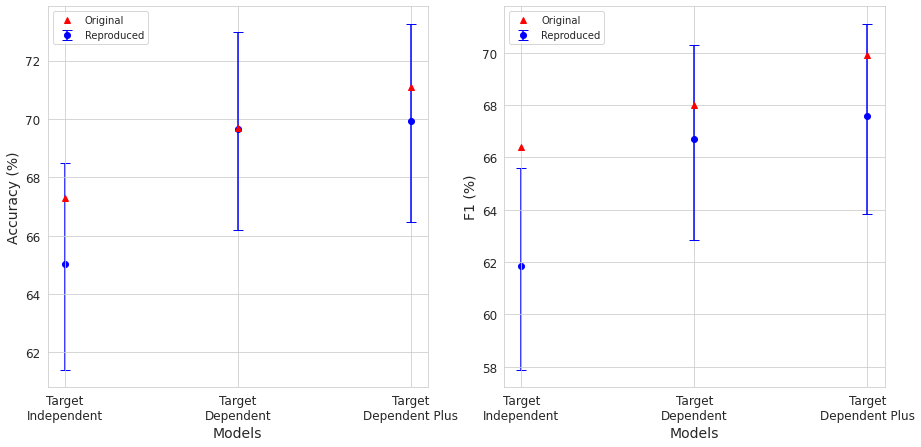

In [12]:
# Load true labels from the test set
dong_test_y = np.array(dong_test.sentiment_data())
# Create P-values for the accuracy metric using bootstrap
target_bootstrap_acc_preds = thesis_stats.bootstrap(dong_test_y, target_preds, accuracy_score, n=10000)
target_acc_p_values = thesis_stats.bootstrap_one_t_test(target_bootstrap_acc_preds, target_pred_model_names)
# Create P-values for the Macro-F1 metric using bootstrap
target_bootstrap_f1_preds = thesis_stats.bootstrap(dong_test_y, target_preds, f1_score, average='macro', n=10000)
target_f1_p_values = thesis_stats.bootstrap_one_t_test(target_bootstrap_f1_preds, target_pred_model_names)

image_dir = config.IMAGES_DIR / 'Reproduction'
image_dir.mkdir(exist_ok=True, parents=True)
target_boot_preds = [target_bootstrap_acc_preds, target_bootstrap_f1_preds]
metric_funcs = [accuracy_score, f1_score]
metrics_kwargs = [None, {'average': 'macro'}]
metric_names = ['Accuracy', 'F1']
target_orginial_scores = [[67.3, 69.7, 71.1], [66.4, 68.0, 69.9]]
ax = confidence_plots(target_preds, target_boot_preds, dong_test_y, metric_funcs, metrics_kwargs, metric_names, target_pred_model_names, target_orginial_scores, 'Dong', 'Target')
image_fp = str(Path(image_dir, 'Target_Reproduction_Dong.pdf').resolve())
ax.figure.savefig(image_fp, bbox_inches='tight')

As we can see from the plots, all models that the original paper shared results for are not significantly different to the ones reproduced here. The only expception to that is the Target Independent model on the F1 metric, but for the accuracy metric it is with the 95% confidence bounds (using a two tailed test), thus conclude that all models have been reproduced successfully. We now test unlike the original paper wether any of the models are significantly different to each other:

In [8]:
# Load true labels from the test set
dong_test_y = np.array(dong_test.sentiment_data())
# Create P-values for the accuracy metric using bootstrap
all_target_bootstrap_acc_preds = thesis_stats.bootstrap(dong_test_y, all_target_preds, accuracy_score, n=10000)
all_target_acc_p_values = thesis_stats.bootstrap_one_t_test(all_target_bootstrap_acc_preds, all_target_pred_model_names)
# Create P-values for the Macro-F1 metric using bootstrap
all_target_bootstrap_f1_preds = thesis_stats.bootstrap(dong_test_y, all_target_preds, f1_score, average='macro', n=10000)
all_target_f1_p_values = thesis_stats.bootstrap_one_t_test(all_target_bootstrap_f1_preds, all_target_pred_model_names)
multi_metric_df({'F1': all_target_f1_p_values, 'Accuracy': all_target_acc_p_values})

F1                         \
                       Target Independent Target Dependent Minus   
Target Independent                 1.0000                 0.4541   
Target Dependent Minus             0.5459                 1.0000   
Target Dependent                   0.9976                 0.9995   
Target Dependent Plus              0.9995                 0.9994   

                                                               \
                       Target Dependent Target Dependent Plus   
Target Independent               0.0024                0.0005   
Target Dependent Minus           0.0005                0.0006   
Target Dependent                 1.0000                0.2394   
Target Dependent Plus            0.7606                1.0000   

                                 Accuracy                         \
                       Target Independent Target Dependent Minus   
Target Independent                 1.0000                 0.1962   
Target Dependent Minus             0.8245                 1.0000   
Target Dependent                   0.9987                 0.9935   
Target Dependent Plus              0.9986                 0.9905   

                                                               
                       Target Dependent Target Dependent Plus  
Target Independent               0.0017                0.0019  
Target Dependent Minus           0.0094                0.0121  
Target Dependent                 1.0000                0.4223  
Target Dependent Plus            0.6284                1.0000

As we can see from above only the Target Dependent and Target Dependent Plus models are significantly better than the non-target model (Target Independent). Furthermore the Target Dependent model is significantly better than Target Dependent Minus indicating that incorporating the target word into the model is significantly important, this significant difference was not shown in the original paper. Lastly including sentiment lexicons is not shown here to be significantly better than not unlike the cross validation/development experiments. 

#### Scaling
Up until now all of the models have had their features scaled using Max Min scaling where the feature range value is between a minimum of 0 and a mximum of 1. Scaling however was never mentioned in the original paper. Thus below we show that without scaling the findings will be significantly different:

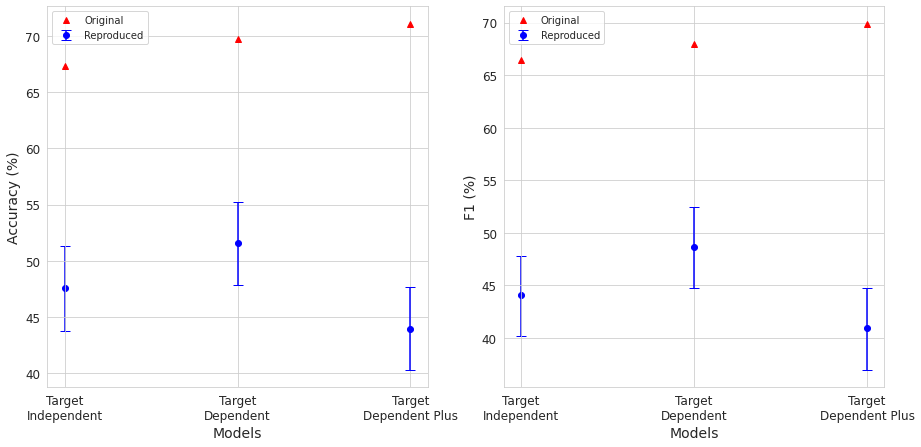

In [13]:
results_dir = config.RESULTS_DIR
# Run the Target models
target_ind_non_scaled = target.TargetInd([w2v_dong, sswe_dong], C=0.12, scale=None)
target_dep_non_scaled = target.TargetDep([w2v_dong, sswe_dong], C=0.01, scale=None)
target_dep_plus_non_scaled = target.TargetDepPlus([w2v_dong, sswe_dong], 
                                                   mpqa_huliu, C=0.01, scale=None)

target_models_non_scaled = [target_ind_non_scaled, target_dep_non_scaled,
                            target_dep_plus_non_scaled]
target_model_names_non_scaled = ['Target Independent',  
                                 'Target Dependent', 
                                 'Target Dependent Plus']

# For the significance testing
target_non_scaled_preds = []

for model in target_models_non_scaled:
    preds = method_predictions(dong_train, dong_test, model, results_dir, 
                               save_name_addon='Non Scaled')
    preds = np.expand_dims(np.array(preds), 1)
    target_non_scaled_preds.append(preds)
target_non_scaled_preds = np.concatenate(target_non_scaled_preds, 1)


# Load true labels from the test set
dong_test_y = np.array(dong_test.sentiment_data())
# Create P-values for the accuracy metric using bootstrap
ns_target_bootstrap_acc_preds = thesis_stats.bootstrap(dong_test_y, target_non_scaled_preds, accuracy_score, n=10000)
# Create P-values for the Macro-F1 metric using bootstrap
ns_target_bootstrap_f1_preds = thesis_stats.bootstrap(dong_test_y, target_non_scaled_preds, f1_score, average='macro', n=10000)

ns_target_boot_preds = [ns_target_bootstrap_acc_preds, ns_target_bootstrap_f1_preds]
metric_funcs = [accuracy_score, f1_score]
metrics_kwargs = [None, {'average': 'macro'}]
metric_names = ['Accuracy', 'F1']
target_orginial_scores = [[67.3, 69.7, 71.1], [66.4, 68.0, 69.9]]
ax = confidence_plots(target_non_scaled_preds, ns_target_boot_preds, dong_test_y, metric_funcs, metrics_kwargs, metric_names, target_model_names_non_scaled, target_orginial_scores, 'Dong', 'Target')
image_fp = str(Path(image_dir, 'Target_Non_Scaled_Reproduction_Dong.pdf').resolve())
ax.figure.savefig(image_fp, bbox_inches='tight')


Within [Wang et al. 2017](https://www.aclweb.org/anthology/E17-1046.pdf) they scaled the data between -1 and 1 (this was found through their codebase and not their paper, link to the relevant part of the [codebase](https://github.com/bluemonk482/tdparse/blob/master/src/liblinear.py)) where as in this work we scale between 0 and 1, thus below we see if using the -1 and 1 scale will also reproduce the result from this paper by [Vo et al. 2015](https://ijcai.org/Proceedings/15/Papers/194.pdf).

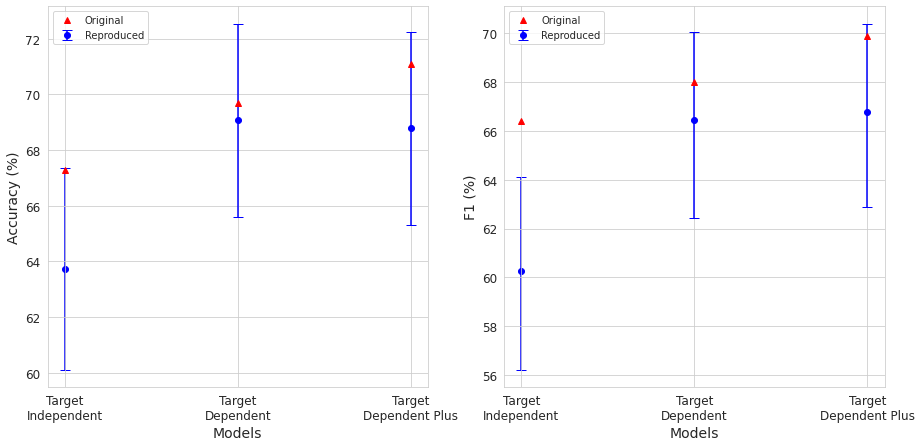

In [15]:
from sklearn.preprocessing import MinMaxScaler

alt_scaler = MinMaxScaler(feature_range=(-1,1))
results_dir = config.RESULTS_DIR
# Run the Target models
target_ind_diff_scaled = target.TargetInd([w2v_dong, sswe_dong], C=0.12, scale=alt_scaler)
target_dep_diff_scaled = target.TargetDep([w2v_dong, sswe_dong], C=0.01, scale=alt_scaler)
target_dep_plus_diff_scaled = target.TargetDepPlus([w2v_dong, sswe_dong], 
                                                   mpqa_huliu, C=0.01, scale=alt_scaler)

target_models_diff_scaled = [target_ind_diff_scaled, target_dep_diff_scaled,
                             target_dep_plus_diff_scaled]
target_model_names_diff_scaled = ['Target Independent',  
                                  'Target Dependent', 
                                  'Target Dependent Plus']

# For the significance testing
target_diff_scaled_preds = []

for model in target_models_diff_scaled:
    preds = method_predictions(dong_train, dong_test, model, results_dir, 
                               save_name_addon='Wang Scaled')
    preds = np.expand_dims(np.array(preds), 1)
    target_diff_scaled_preds.append(preds)
target_diff_scaled_preds = np.concatenate(target_diff_scaled_preds, 1)


# Load true labels from the test set
dong_test_y = np.array(dong_test.sentiment_data())
# Create P-values for the accuracy metric using bootstrap
diff_target_bootstrap_acc_preds = thesis_stats.bootstrap(dong_test_y, target_diff_scaled_preds, accuracy_score, n=10000)
# Create P-values for the Macro-F1 metric using bootstrap
diff_target_bootstrap_f1_preds = thesis_stats.bootstrap(dong_test_y, target_diff_scaled_preds, f1_score, average='macro', n=10000)

diff_target_boot_preds = [diff_target_bootstrap_acc_preds, diff_target_bootstrap_f1_preds]
metric_funcs = [accuracy_score, f1_score]
metrics_kwargs = [None, {'average': 'macro'}]
metric_names = ['Accuracy', 'F1']
target_orginial_scores = [[67.3, 69.7, 71.1], [66.4, 68.0, 69.9]]
ax = confidence_plots(target_diff_scaled_preds, diff_target_boot_preds, dong_test_y, metric_funcs, metrics_kwargs, metric_names, target_model_names_diff_scaled, target_orginial_scores, 'Dong', 'Target')
image_fp = str(Path(image_dir, 'Target_Wang_Scaled_Reproduction_Dong.pdf').resolve())
ax.figure.savefig(image_fp, bbox_inches='tight')



As we can see from above using the different scale range only just reproduces the results from this work, but the results on average are not as good as using the scale range of 0 to 1. Furthermore for the accuracy metric we can see that the Target Dependent Model is better than the Plus version which is not the case in the original work. This suggests that using the 0 to 1 range is better on average but significantly in-different.